In [1]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
import warnings
warnings.simplefilter('once', category=UserWarning)

In [14]:
pattern = os.path.join('/home/tbellagio/scratch/slim_grenenet/results', '**', 'allele_freq.csv')

In [ ]:
allele_freq_files = glob.glob(pattern, recursive=True)

In [4]:
allele_freq_founder_file = '/home/tbellagio/scratch/slim_grenenet/data/allele_freq_founder_offset.csv'
allele_freq_founder = pd.read_csv(allele_freq_founder_file)

In [5]:
def calc_delta_p(allele_freq,allele_freq_founder ): 
    allele_freq_founder['chrom_pos'] = allele_freq_founder['chrom_pos'].astype(int)
    ## eliminate duplciates basically positions where the allele freq is the same in all 
    allele_freq = allele_freq.round(6)

    allele_freq = allele_freq.set_index('chrom_pos')   #.drop_duplicates()
    allele_freq = allele_freq.reset_index()
    allele_freq = allele_freq.fillna(0)

    ## first calculate delta p norm 
    ## imoport allele freq of the founder and normalize 
    allele_freq = pd.merge(allele_freq,allele_freq_founder, on ='chrom_pos')
    allele_freq = allele_freq.set_index('chrom_pos')
    
    delta_p = pd.DataFrame() #index = allele_freq.index

    for col in allele_freq.columns:
        delta_p[col] = allele_freq[col] - allele_freq['allele_freq_founder']
        
    delta_p = delta_p.drop(['allele_freq_founder','deno_norm'],axis=1)

    #delta_p = delta_p.round(6)
    ## eliminate rows with all the same values
    #delta_p = delta_p[delta_p.std(axis=1) > 0]
    return delta_p

In [6]:
def calc_delta_p_norm(allele_freq,allele_freq_founder ): 
    allele_freq_founder['chrom_pos'] = allele_freq_founder['chrom_pos'].astype(int)
    ## eliminate duplciates basically positions where the allele freq is the same in all 
    allele_freq = allele_freq.round(6)

    allele_freq = allele_freq.set_index('chrom_pos')   #.drop_duplicates()
    allele_freq = allele_freq.reset_index()
    allele_freq = allele_freq.fillna(0)

    ## first calculate delta p norm 
    ## imoport allele freq of the founder and normalize 
    allele_freq = pd.merge(allele_freq,allele_freq_founder, on ='chrom_pos')
    allele_freq = allele_freq.set_index('chrom_pos')
    
    delta_p_norm = pd.DataFrame() #index = allele_freq.index

    for col in allele_freq.columns:
        delta_p_norm[col] = (allele_freq[col] - allele_freq['allele_freq_founder']) / allele_freq['deno_norm']
        
    delta_p_norm = delta_p_norm.drop(['allele_freq_founder','deno_norm'],axis=1)

    #delta_p_norm = delta_p_norm.round(6)
    ## eliminate rows with all the same values
    #delta_p_norm = delta_p_norm[delta_p_norm.std(axis=1) > 0]
    return delta_p_norm

In [7]:
def calc_rsquared_values(df, name, env, site):
    # Check if 'chrom_pos' column exists in the DataFrame

    p_values = []
    slopes = []
    
    for index, row in df.iterrows():
        # Fit a mixed model for each row
        myd = pd.DataFrame({'y': row[1:].astype(float), 'env': env, 'site': site})

        md = smf.mixedlm("y ~ env", myd, groups=myd["site"], ) #re_formula="~env"
        res = md.fit(method='cg')
        
        # Append p-value and slope to lists
        p_values.append(res.pvalues['env'])
        slopes.append(res.params['env'])
    
    # Create a DataFrame to store the results
    rsquared_values = pd.DataFrame({'chrom_pos': df['chrom_pos'], 'p_values': p_values, 'slopes': slopes, 'model': name})
    
    return rsquared_values


In [8]:
right_order_cols = ['chrom_pos', 'optima-2_subp1', 'optima-2_subp2', 'optima-2_subp3',
       'optima-2_subp4', 'optima-2_subp5', 'optima-1_subp1', 'optima-1_subp2',
       'optima-1_subp3', 'optima-1_subp4', 'optima-1_subp5', 'optima0_subp1',
       'optima0_subp2', 'optima0_subp3', 'optima0_subp4', 'optima0_subp5',
       'optima1_subp1', 'optima1_subp2', 'optima1_subp3', 'optima1_subp4',
       'optima1_subp5', 'optima2_subp1', 'optima2_subp2', 'optima2_subp3',
       'optima2_subp4', 'optima2_subp5']

In [9]:
def create_df_r2 (path_allele_freq, heritability, freq, pi, rep, right_order_cols):

    causal_loci_file = path_allele_freq.split('arq')[0] + 'arq' + path_allele_freq.split('arq')[1].split('/')[0] + '/loci_effectsize.csv'
    causal_loci = pd.read_csv(causal_loci_file, index_col = [0])
    allele_freq = pd.read_csv(path_allele_freq)
    allele_freq = allele_freq[allele_freq['chrom_pos'].isin(causal_loci.pos)]
    allele_freq = allele_freq.drop('Unnamed: 0',axis=1)
    
    allele_freq = allele_freq.fillna(0)

    allele_freq = allele_freq.set_index('chrom_pos').drop_duplicates().reset_index()
    
    delta_p = calc_delta_p(allele_freq,allele_freq_founder )
    delta_p_norm = calc_delta_p_norm(allele_freq,allele_freq_founder )
    delta_p = delta_p.reset_index()
    delta_p_norm = delta_p_norm.reset_index()
    allele_freq = allele_freq[right_order_cols]
    delta_p = delta_p[right_order_cols]
    delta_p_norm = delta_p_norm[right_order_cols]
    
    allele_freq_r2 = calc_rsquared_values(allele_freq, 'allele_freq', env, site)
    delta_p_r2 = calc_rsquared_values(delta_p,'delta_p' , env, site)
    delta_p_norm_r2 = calc_rsquared_values(delta_p_norm, 'delta_p_norm', env, site)
    
    all_transformations = pd.concat([allele_freq_r2, delta_p_r2, delta_p_norm_r2],axis=0)
    all_transformations = all_transformations.merge(causal_loci, left_on ='chrom_pos', right_on= 'pos', how= 'left').drop('pos',axis=1)
    #all_transformations = pd.merge(allele_freq_r2,delta_p_r2, on = 'chrom_pos').merge(delta_p_norm_r2,  on = 'chrom_pos')

    #all_transformations = all_transformations.merge(causal_loci, left_on ='chrom_pos', right_on= 'pos').drop('pos',axis=1)
    #all_transformations['sc_abs'] = all_transformations['sc'].abs()
    #all_transformations = all_transformations.sort_values(by = 'sc_abs')
    #all_transformations = all_transformations.drop(['chrom_pos', 'sc_abs'],axis=1) #.set_index('sc')
    #all_transformations['sc'] = all_transformations['sc'].round(4)
    #all_transformations = all_transformations.set_index('sc')
    #all_transformations_melt = all_transformations.reset_index().melt(id_vars=['sc'])
    
    all_transformations['heritability'] = heritability
    all_transformations['freq'] = freq
    all_transformations['pi'] = pi
    all_transformations['rep'] = rep
    return all_transformations

In [10]:
allele_freq_files = [i for i in allele_freq_files if '/strongsel' in i]

NameError: name 'allele_freq_files' is not defined

In [11]:
path_allele_freq  = '/home/tbellagio/scratch/slim_grenenet/results/arq_mediumfreq_onehpoly_4/mediumh/strongsel/allele_freq.csv'

In [12]:
path_allele_freq_norm  = '/home/tbellagio/scratch/slim_grenenet/results/arq_mediumfreq_onehpoly_4/mediumh/strongsel/allele_freq_norm.csv'

In [13]:
allele_freq_norm = pd.read_csv(path_allele_freq_norm)

In [16]:
allele_freq_norm = allele_freq_norm[allele_freq_norm['chrom_pos'].isin(causal_loci.pos)]

In [15]:
causal_loci_file = path_allele_freq.split('arq')[0] + 'arq' + path_allele_freq.split('arq')[1].split('/')[0] + '/loci_effectsize.csv'
causal_loci = pd.read_csv(causal_loci_file, index_col = [0])
allele_freq = pd.read_csv(path_allele_freq)
allele_freq = allele_freq[allele_freq['chrom_pos'].isin(causal_loci.pos)]
allele_freq = allele_freq.drop('Unnamed: 0',axis=1)

allele_freq = allele_freq.fillna(0)
#allele_freq = allele_freq.round(10)
allele_freq = allele_freq.set_index('chrom_pos').drop_duplicates().reset_index()

delta_p = calc_delta_p(allele_freq,allele_freq_founder )
delta_p_norm = calc_delta_p_norm(allele_freq,allele_freq_founder )
delta_p = delta_p.reset_index()
delta_p_norm = delta_p_norm.reset_index()
allele_freq = allele_freq[right_order_cols]
delta_p = delta_p[right_order_cols]
delta_p_norm = delta_p_norm[right_order_cols]



In [19]:
allele_freq_norm

,chrom_pos,optima-2_subp1,optima-2_subp2,optima-2_subp3,optima-2_subp4,optima-2_subp5,optima-1_subp1,optima-1_subp2,optima-1_subp3,optima-1_subp4,...,optima1_subp1,optima1_subp2,optima1_subp3,optima1_subp4,optima1_subp5,optima2_subp1,optima2_subp2,optima2_subp3,optima2_subp4,optima2_subp5
1696,139832,0.598393,-0.063598,0.564651,0.161350,0.607231,-0.039095,-0.202182,-0.074845,-0.057171,...,-0.204191,-0.195354,-0.123852,-0.045924,-0.094930,-0.684617,-0.499034,-0.282923,-0.678189,-0.507470
12992,1141897,3.549682,3.049094,5.400982,2.313140,4.029194,0.370505,0.428468,0.027997,0.769219,...,-0.439219,-0.811587,-0.361935,-0.820369,-0.537581,-1.064516,-1.064516,-1.064516,-1.064516,-1.064516
46583,4317823,1.886116,1.277630,2.726884,0.905979,1.539060,0.476030,0.597181,0.526130,0.885939,...,-0.723636,-0.632545,-0.541454,-0.434878,-0.490443,-1.089821,-0.934966,-1.143564,-1.114415,-1.110772
58614,5409909,-0.913857,-1.023927,-1.143743,-1.103040,-0.989530,-0.535492,-0.608872,-0.545237,-0.583647,...,0.384624,0.365706,0.499281,0.550303,0.865607,-0.051069,-0.311339,-0.514280,-0.200696,0.137540
63516,5829776,-0.969514,-0.488291,-0.384736,-0.234481,-0.729918,0.074152,0.287352,-0.141079,0.309688,...,0.265017,-0.559358,-0.118743,-0.547175,-0.457834,-1.054795,-0.912661,-0.687278,-0.924844,-0.762405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389706,108676221,-0.214344,-0.756984,-0.153010,-0.916283,-0.077620,-0.063564,-0.151306,-0.042267,-0.262475,...,0.090198,-0.006915,-0.070805,-0.167918,0.066346,-0.019267,0.533170,0.379408,0.198812,0.440742
1392671,108826436,-0.692683,0.197510,-0.237470,0.096352,0.810783,-0.294372,-0.223561,-0.363918,-0.588995,...,-0.160337,-0.195742,-0.350009,-0.181833,0.211420,0.430175,-0.471399,-0.068030,-0.185627,1.005512
1434355,111137094,-0.990745,-0.867794,-0.936295,-1.064516,-0.904679,-0.323294,-0.469079,-0.196829,-0.175752,...,0.702474,0.310785,0.389826,-0.263574,-0.254792,0.484674,0.728821,1.282103,0.871094,0.393339
1484836,114994901,-0.337285,0.286854,-0.295846,0.314905,-0.091837,0.766274,0.497238,0.663632,0.610718,...,-0.657323,-0.455865,-0.657323,-0.452040,-0.438014,-1.007326,-1.141206,-1.173083,-1.018164,-0.850494


In [23]:
os.listdir('/carnegie/nobackup/scratch/tbellagio/slim_grenenet/results/arq_mediumfreq_onehpoly_4/mediumh/strongsel')

['ecotype_counts.csv',
 'lmm_resultslmer_.csv',
 'allele_freq_norm.csv',
 'optima2',
 'optima1',
 'lmm_resultsnlme.csv',
 'lmm',
 'optima-2',
 'optima0',
 'optima-1',
 'allele_freq.csv',
 'allele_counts.csv']

In [34]:
resultsr = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/slim_grenenet/results/arq_mediumfreq_onehpoly_4/mediumh/strongsel/lmm_resultslmer_.csv')

In [28]:
resultsrmeixi = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/slim_grenenet/results/arq_mediumfreq_onehpoly_4/mediumh/strongsel/lmm_resultsnlme.csv')

<Axes: xlabel='beta_p', ylabel='Count'>

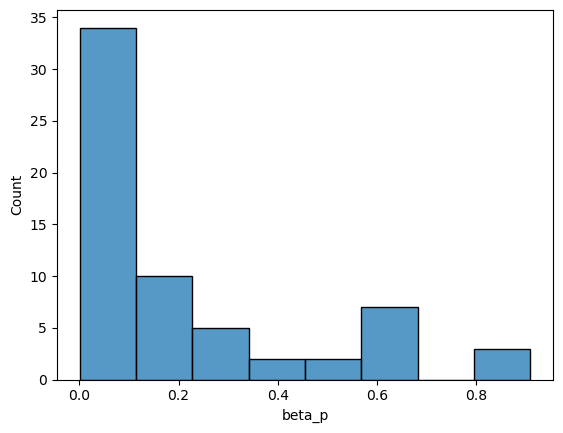

In [31]:
sns.histplot(resultsrmeixi['beta_p'])

In [33]:
resultsrmeixi['beta_p'][resultsrmeixi['beta_p'] < 5e-8]

Series([], Name: beta_p, dtype: float64)

In [35]:
resultsr['X2'][resultsr['X2'] < 5e-8]

45    2.928408e-10
54    6.393176e-11
56    7.510749e-17
Name: X2, dtype: float64

In [50]:
resultsrmeixi[resultsr['X2'].round(6) != resultsrmeixi['beta_p'].round(6)]

,Unnamed: 0,R2m,R2c,beta,beta_p,BIC
10,result.11,0.501515,0.733313,0.356263,0.062218,44.852556
15,result.16,0.503767,0.503767,0.189799,0.015945,25.036373
22,result.23,0.033285,0.471818,0.055513,0.625580,37.331007
27,result.28,0.407094,0.791304,-0.205201,0.121640,20.572997
37,result.38,0.702641,0.702641,0.186362,0.004854,4.764639
45,result.46,0.821704,0.821704,0.266990,0.001836,5.937752
47,result.48,0.002237,0.635669,0.014962,0.909666,32.473688
54,result.55,0.843505,0.843505,-0.452533,0.001458,26.607690
56,result.57,0.951825,0.951825,0.588143,0.000212,8.787589


In [49]:
resultsr[resultsr['X2'].round(6) != resultsrmeixi['beta_p'].round(6)]

,Unnamed: 0,X1,X2,chrom_pos
10,11,0.356263,6.221731e-02,20480792
15,16,0.189799,5.466422e-05,25520639
22,23,0.055513,6.255784e-01,30896292
27,28,-0.205201,1.216406e-01,37079156
37,38,0.186362,1.191046e-07,54788207
45,46,0.266990,2.928408e-10,80423693
47,48,0.014962,9.096668e-01,84254948
54,55,-0.452533,6.393176e-11,102400150
56,57,0.588143,7.510749e-17,106721518


In [37]:
resultsrmeixi['beta_p']

0     0.051620
1     0.045649
2     0.002048
3     0.177499
4     0.502346
        ...   
58    0.019056
59    0.630221
60    0.006018
61    0.097897
62    0.008859
Name: beta_p, Length: 63, dtype: float64

In [26]:
allele_freq_norm_r2.merge(resultsr, on = 'chrom_pos')

,chrom_pos,p_values,slopes,model,Unnamed: 0,X1,X2
0,139832,1.682782e-03,-0.183301,delta_p_norm,1,-0.183301,0.051620
1,1141897,9.583972e-04,-1.041822,delta_p_norm,2,-1.041822,0.045649
2,4317823,3.983641e-24,-0.672651,delta_p_norm,3,-0.672651,0.002048
3,5409909,7.923123e-02,0.278855,delta_p_norm,4,0.278855,0.177499
4,5829776,4.470497e-01,-0.106113,delta_p_norm,5,-0.106113,0.502346
...,...,...,...,...,...,...,...
58,108676221,3.787248e-06,0.154742,delta_p_norm,59,0.154742,0.019056
59,108826436,5.931650e-01,0.047013,delta_p_norm,60,0.047013,0.630221
60,111137094,2.809569e-12,0.381396,delta_p_norm,61,0.381396,0.006018
61,114994901,1.745610e-02,-0.317935,delta_p_norm,62,-0.317935,0.097897


In [21]:
allele_freq_norm_r2 = calc_rsquared_values(allele_freq_norm, 'delta_p_norm', env, site)

/home/tbellagio/mambaforge/envs/pipeline_snakemake/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tbellagio/mambaforge/envs/pipeline_snakemake/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/tbellagio/mambaforge/envs/pipeline_snakemake/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 0.390061
  warnings.warn(msg, ConvergenceWarning)
/home/tbellagio/mambaforge/envs/pipeline_snakemake/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarn

In [108]:
df = allele_freq_norm.copy()

In [110]:
myd

,y,env,site
optima-2_subp1,-0.663799,-2,optima-2
optima-2_subp2,-0.501539,-2,optima-2
optima-2_subp3,-0.514520,-2,optima-2
optima-2_subp4,-0.624856,-2,optima-2
optima-2_subp5,-0.231938,-2,optima-2
optima-1_subp1,-0.004774,-1,optima-1
optima-1_subp2,-0.212966,-1,optima-1
optima-1_subp3,-0.151557,-1,optima-1
optima-1_subp4,-0.212966,-1,optima-1
optima-1_subp5,-0.448617,-1,optima-1


In [ ]:
! 

In [ ]:
p_values = []
slopes = []

for index, row in df.iterrows():
    # Fit a mixed model for each row
    myd = pd.DataFrame({'y': row[1:].astype(float), 'env': env, 'site': site})

    md = smf.mixedlm("y ~ env", myd, groups=myd["site"], re_formula="~env")
    res = md.fit(optimizer='bfgs')

    # Append p-value and slope to lists
    p_values.append(res.pvalues['env'])
    slopes.append(res.params['env'])

# Create a DataFrame to store the results
rsquared_values = pd.DataFrame({'chrom_pos': df['chrom_pos'], 'p_values': p_values, 'slopes': slopes, 'model': name})

In [89]:
allele_freq_norm_r2.merge(delta_p_norm_r2, on = 'chrom_pos')

,chrom_pos,p_values_x,slopes_x,model_x,p_values_y,slopes_y,model_y
0,139832,1.682571e-03,-0.183301,delta_p_norm,1.682571e-03,-0.183301,delta_p_norm
1,1141897,9.583336e-04,-1.041822,delta_p_norm,9.583336e-04,-1.041822,delta_p_norm
2,4317823,3.985200e-24,-0.672651,delta_p_norm,3.985200e-24,-0.672651,delta_p_norm
3,5409909,7.923091e-02,0.278855,delta_p_norm,7.923091e-02,0.278855,delta_p_norm
4,5829776,4.470445e-01,-0.106113,delta_p_norm,4.470445e-01,-0.106113,delta_p_norm
...,...,...,...,...,...,...,...
58,108676221,7.515496e-06,0.154742,delta_p_norm,7.515496e-06,0.154742,delta_p_norm
59,108826436,5.931652e-01,0.047013,delta_p_norm,5.931652e-01,0.047013,delta_p_norm
60,111137094,2.808861e-12,0.381396,delta_p_norm,2.808861e-12,0.381396,delta_p_norm
61,114994901,1.746123e-02,-0.317935,delta_p_norm,1.746123e-02,-0.317935,delta_p_norm


In [86]:
delta_p_norm_r2

,chrom_pos,p_values,slopes,model
0,139832,1.682571e-03,-0.183301,delta_p_norm
1,1141897,9.583336e-04,-1.041822,delta_p_norm
2,1798053,2.249043e-03,0.940902,delta_p_norm
3,4317823,3.985200e-24,-0.672651,delta_p_norm
4,5409909,7.923091e-02,0.278855,delta_p_norm
...,...,...,...,...
94,111787541,1.727807e-01,-0.216251,delta_p_norm
95,114994901,1.746123e-02,-0.317935,delta_p_norm
96,115027086,8.471468e-12,-0.323423,delta_p_norm
97,117188081,2.144853e-02,-0.239334,delta_p_norm


In [ ]:
allele_freq_r2 = calc_rsquared_values(allele_freq, 'allele_freq', env, site)
delta_p_r2 = calc_rsquared_values(delta_p,'delta_p' , env, site)

all_transformations = pd.concat([allele_freq_r2, delta_p_r2, delta_p_norm_r2],axis=0)
all_transformations = all_transformations.merge(causal_loci, left_on ='chrom_pos', right_on= 'pos', how= 'left').drop('pos',axis=1)

In [13]:
#allele_freq_files = [i for i in allele_freq_files if 'highh' in i]
#allele_freq_files = [i for i in allele_freq_files if 'lowfreq' in i]
#allele_freq_files = [i for i in allele_freq_files if '_1' in i]

files = pd.DataFrame({'file': allele_freq_files})
files['heritability'] = files['file'].str.split('/').str[-3]
files['freq'] = files['file'].str.split('/').str[-4].str.split('_').str[1]
files['pi'] = files['file'].str.split('/').str[-4].str.split('_').str[2]
files['rep'] = files['file'].str.split('/').str[-4].str.split('_').str[3]

In [14]:
file = files.loc[0, 'file']
heritability = files.loc[0, 'heritability']
freq = files.loc[0, 'freq']
pi = files.loc[0, 'pi']
rep = files.loc[0, 'rep']

In [17]:
## define env variable 
env= np.array([-2,-2,-2,-2,-2,-1,-1,-1,-1,-1,0,0,0,0,0,1,1,1,1,1,2,2,2,2,2])

In [18]:
site = ['optima-2', 'optima-2', 'optima-2', 'optima-2', 'optima-2',
       'optima-1', 'optima-1', 'optima-1', 'optima-1', 'optima-1',
       'optima0', 'optima0', 'optima0', 'optima0', 'optima0', 'optima1',
       'optima1', 'optima1', 'optima1', 'optima1', 'optima2', 'optima2',
       'optima2', 'optima2', 'optima2']

In [17]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


In [18]:


# Filter out UserWarning messages from statsmodels
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

In [ ]:
all_dfr2 = {}
for i in range(len(files)):
    
    file = files.loc[i, 'file']
    print(file)
    heritability = files.loc[i, 'heritability']
    freq = files.loc[i, 'freq']
    pi = files.loc[i, 'pi']
    rep = files.loc[i, 'rep']
    df_r2  = create_df_r2 (file, heritability, freq, pi, rep, right_order_cols)

    #print(df_r2.shape)
    all_dfr2[file] = df_r2
    

In [21]:
all_dfr2 = pd.concat(all_dfr2) #.reset_index(drop=True)

In [60]:
len(files['file'].values)

180

In [ ]:
files['file'].values[0]

'/home/tbellagio/scratch/slim_grenenet/results/arq_highfreq_onehpoly_4/mediumh/strongsel/allele_freq.csv'

In [ ]:
'/home/tbellagio/scratch/slim_grenenet/results/arq_mediumfreq_onehpoly_4/mediumh/strongsel/allele_freq.csv'

In [64]:
all_dfr2['sig'] = all_dfr2['p_values'] < 5e-8

In [66]:
all_dfr2.groupby([ 'heritability', 'freq', 'pi', 'rep'])['sig'].sum().sort_values()

heritability  freq        pi        rep
lowh          lowfreq     monogen   5       0
mediumh       highfreq    monogen   2       0
                                    3       0
                                    4       0
                                    5       0
                                           ..
              mediumfreq  onehpoly  3      63
lowh          mediumfreq  onehpoly  2      69
mediumh       mediumfreq  onehpoly  4      72
              highfreq    onehpoly  4      75
                                    2      75
Name: sig, Length: 180, dtype: int64

In [23]:
all_dfr2 = all_dfr2.reset_index(drop=True)

In [24]:
all_dfr2

,chrom_pos,p_values,slopes,model,sc,heritability,freq,pi,rep
0,1135459,1.900032e-01,-0.004782,allele_freq,1.042827,mediumh,highfreq,onehpoly,4
1,2710060,6.292095e-01,-0.007902,allele_freq,-2.276421,mediumh,highfreq,onehpoly,4
2,2864723,1.688041e-01,-0.014866,allele_freq,1.381345,mediumh,highfreq,onehpoly,4
3,3387729,4.503029e-11,-0.035270,allele_freq,-1.027103,mediumh,highfreq,onehpoly,4
4,9831114,4.282210e-03,-0.018934,allele_freq,1.895886,mediumh,highfreq,onehpoly,4
...,...,...,...,...,...,...,...,...,...
16900,53971167,1.000000e+00,0.000000,delta_p,1.485009,mediumh,lowfreq,monogen,4
16901,53971167,NaN,0.000000,delta_p_norm,1.485009,mediumh,lowfreq,monogen,4
16902,53971167,NaN,0.000000,allele_freq,1.485009,highh,lowfreq,monogen,4
16903,53971167,1.000000e+00,0.000000,delta_p,1.485009,highh,lowfreq,monogen,4


In [26]:
all_dfr2.to_csv('r2_transformations_mixed_model_drop_duplicates.csv')

In [113]:
#all_dfr2 = pd.read_csv('r2_transformations_mixed_model.csv')

In [27]:
all_dfr2.shape

(16905, 9)

In [28]:
all_dfr2['heritability'].unique()

array(['mediumh', 'lowh', 'highh'], dtype=object)

In [29]:
pi_order = ['monogen', 'fivepoly' ,'twentypoly', 'onehpoly']

In [30]:
custom_categories = all_dfr2['sc']

In [31]:
delta_p = all_dfr2[all_dfr2['model'] == 'delta_p']
allele_freq = all_dfr2[all_dfr2['model'] == 'allele_freq']
delta_p_norm = all_dfr2[all_dfr2['model'] == 'delta_p_norm']

In [32]:
col_order = ['lowfreq', 'mediumfreq', 'highfreq']

In [33]:
her_order = ['highh', 'mediumh', 'lowh']

In [34]:
hue=all_dfr2[["heritability", 'model']].apply(tuple, axis=1)

In [35]:
all_dfr2["heritability"].unique()

array(['mediumh', 'lowh', 'highh'], dtype=object)

In [36]:
#colors
custom_categories = her_order
custom_colors = sns.color_palette("Greens", n_colors=len(custom_categories))

# Create a custom color dictionary
custom_color_dict = dict(zip(custom_categories, custom_colors))

In [38]:
#colors
custom_categories = ['allele_freq', 'delta_p',
       'delta_p_norm']
custom_colors = sns.color_palette("Blues", n_colors=len(custom_categories))

# Create a custom color dictionary
custom_color_dictblues = dict(zip(custom_categories, custom_colors))

In [39]:
highh = all_dfr2[all_dfr2['heritability'] == 'highh']

In [40]:
highh = highh.dropna()

In [41]:
highh

,chrom_pos,p_values,slopes,model,sc,heritability,freq,pi,rep
594,1135459,0.486708,-0.003470,allele_freq,1.042827,highh,highfreq,onehpoly,4
595,2710060,0.037688,-0.052708,allele_freq,-2.276421,highh,highfreq,onehpoly,4
596,2864723,0.523520,-0.017598,allele_freq,1.381345,highh,highfreq,onehpoly,4
597,3387729,0.000020,-0.036144,allele_freq,-1.027103,highh,highfreq,onehpoly,4
598,9831114,0.046607,-0.023332,allele_freq,1.895886,highh,highfreq,onehpoly,4
...,...,...,...,...,...,...,...,...,...
16292,117619319,0.995801,0.002143,delta_p_norm,1.514083,highh,mediumfreq,onehpoly,4
16893,9645484,0.078379,-0.220000,allele_freq,-4.004391,highh,highfreq,monogen,5
16894,9645484,0.078379,-0.220000,delta_p,-4.004391,highh,highfreq,monogen,5
16895,9645484,0.078379,-0.903171,delta_p_norm,-4.004391,highh,highfreq,monogen,5


In [151]:
custom_color_dictblues

{'allele_freq': (0.7752402921953095, 0.8583006535947711, 0.9368242983467897),
 'delta_p': (0.41708573625528644, 0.6806305267204922, 0.8382314494425221),
 'delta_p_norm': (0.1271049596309112, 0.4401845444059977, 0.7074971164936563)}

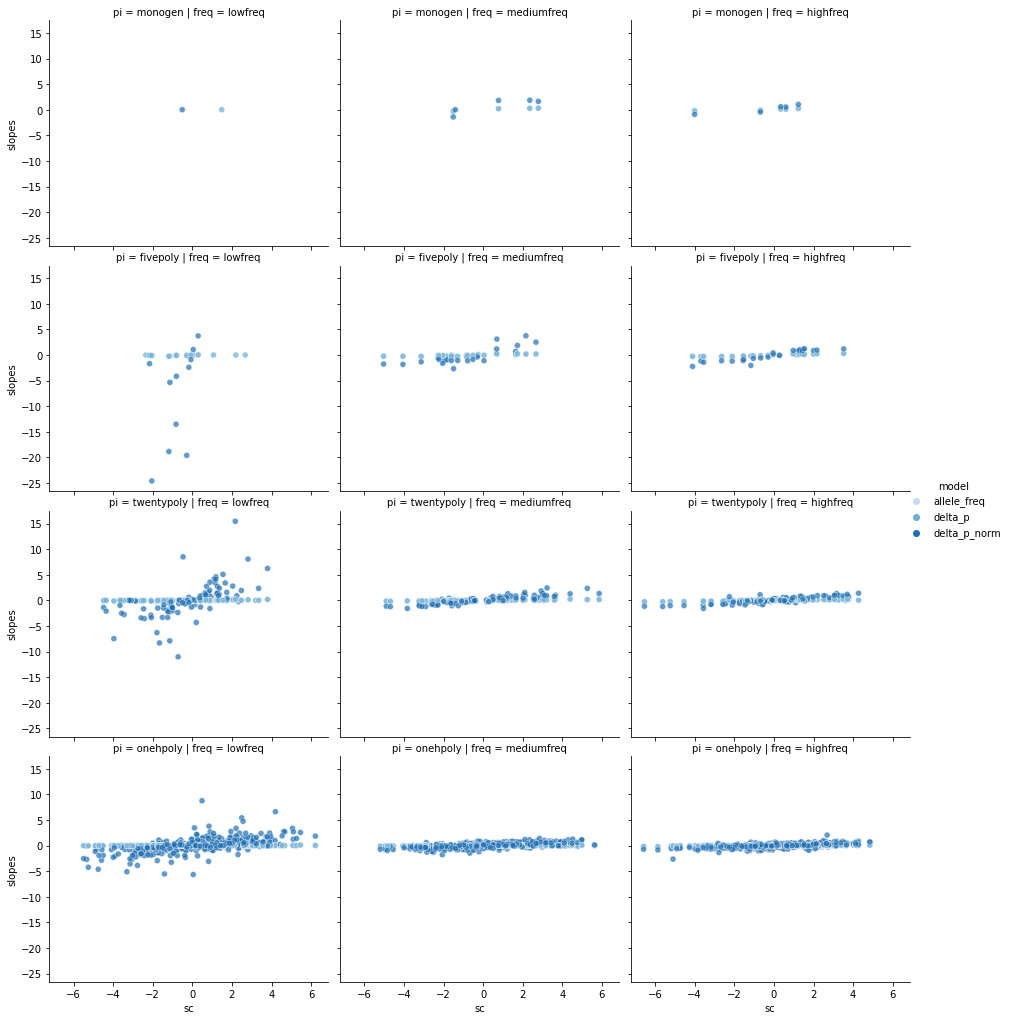

In [42]:
g = sns.relplot(data=highh, x="sc", y="slopes", hue='model', col="freq", row="pi",
                #hue_order = her_order,
                palette=custom_color_dictblues,
                row_order = pi_order,alpha=0.7,
                col_order = col_order
           )
g.fig.set_figheight(14)
g.fig.set_figwidth(14)

plt.show()

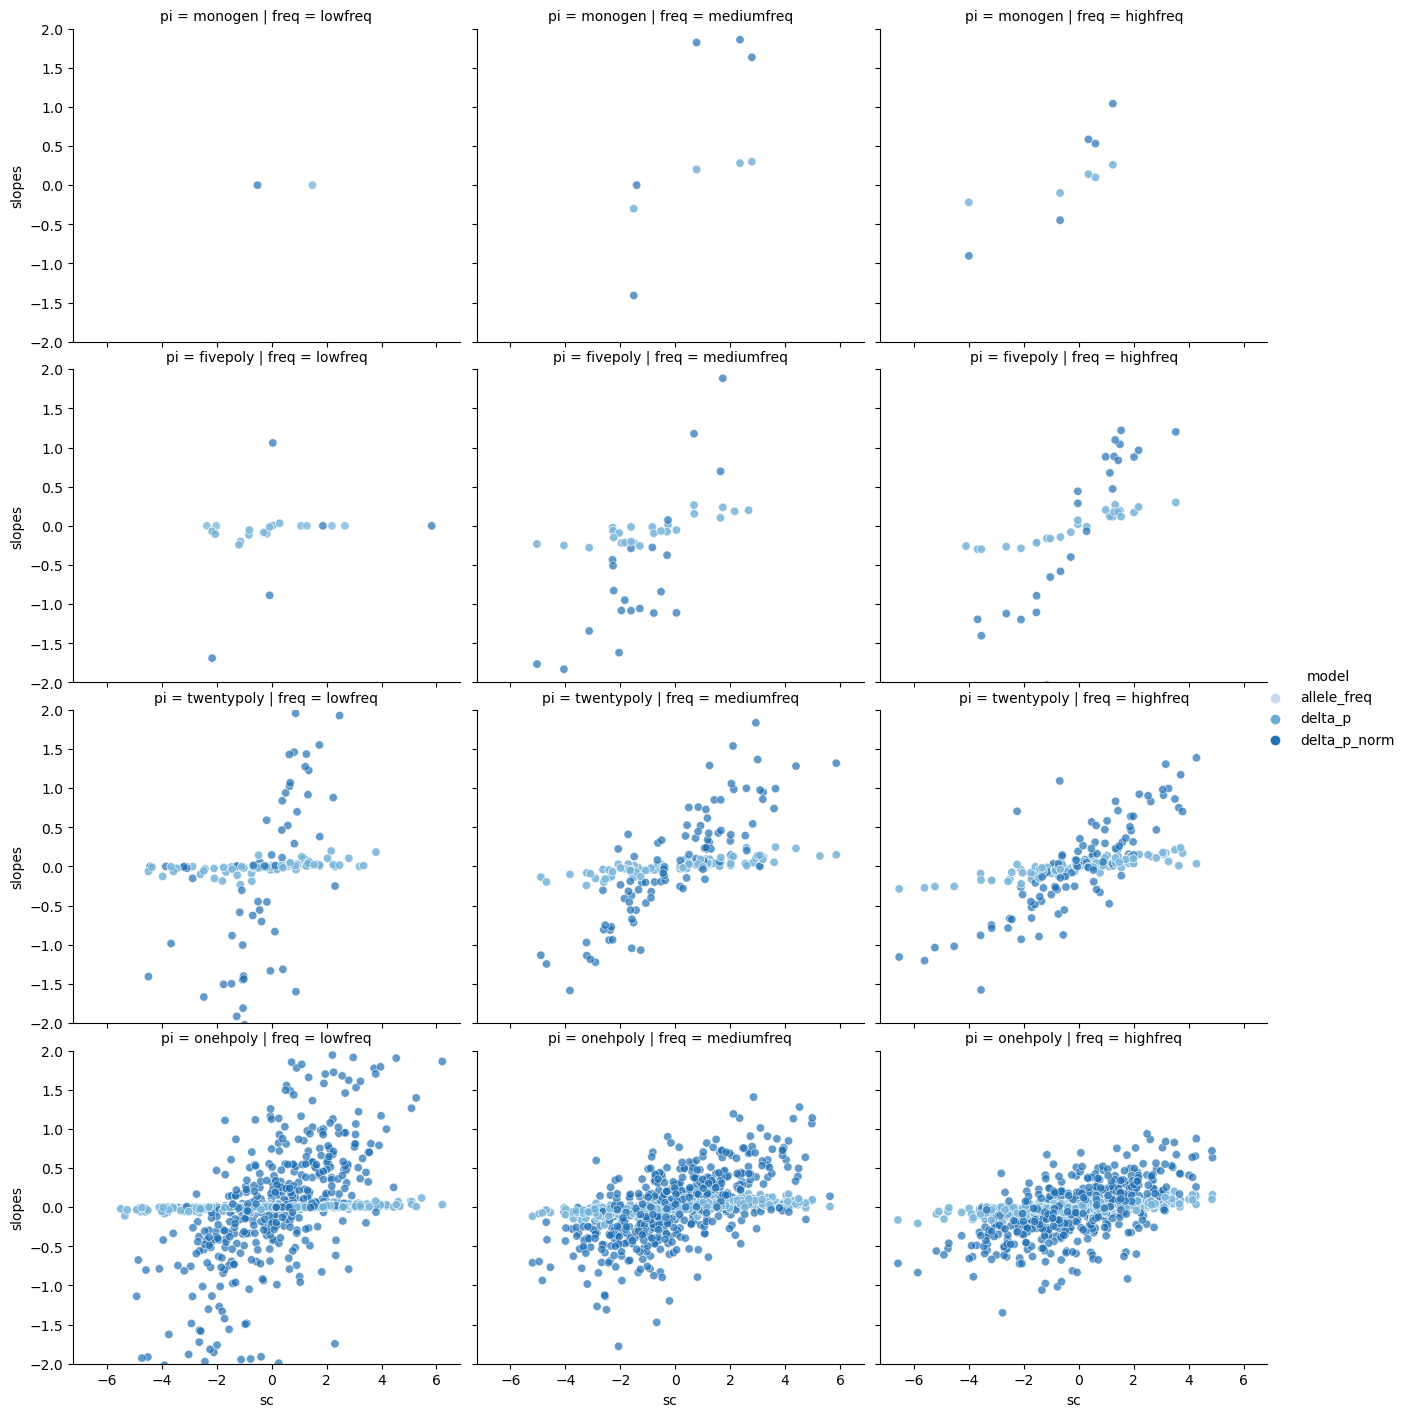

In [155]:
g = sns.relplot(data=highh, x="sc", y="slopes", hue='model', col="freq", row="pi",
                #hue_order = her_order,
                palette=custom_color_dictblues,
                row_order = pi_order,alpha=0.7,
                col_order = col_order
           )
g.fig.set_figheight(14)
g.fig.set_figwidth(14)
g.set(ylim=(-2, +2))  
plt.show()

In [142]:
delta_p_norm

,chrom_pos,p_values,slopes,model,sc,heritability,freq,pi,rep
200,1135459,1.900032e-01,-0.373059,delta_p_norm,1.042827,mediumh,highfreq,onehpoly,4
201,2710060,6.292095e-01,-0.036294,delta_p_norm,-2.276421,mediumh,highfreq,onehpoly,4
202,2864723,1.688041e-01,-0.063614,delta_p_norm,1.381345,mediumh,highfreq,onehpoly,4
203,3387729,4.503029e-11,-0.580877,delta_p_norm,-1.027103,mediumh,highfreq,onehpoly,4
204,9831114,4.282210e-03,-0.263520,delta_p_norm,1.895886,mediumh,highfreq,onehpoly,4
...,...,...,...,...,...,...,...,...,...
16997,9645484,2.011566e-05,-1.229495,delta_p_norm,-4.004391,mediumh,highfreq,monogen,5
17000,9645484,7.837851e-02,-0.903171,delta_p_norm,-4.004391,highh,highfreq,monogen,5
17003,53971167,8.292471e-02,7.602894,delta_p_norm,1.485009,lowh,lowfreq,monogen,4
17006,53971167,NaN,0.000000,delta_p_norm,1.485009,mediumh,lowfreq,monogen,4


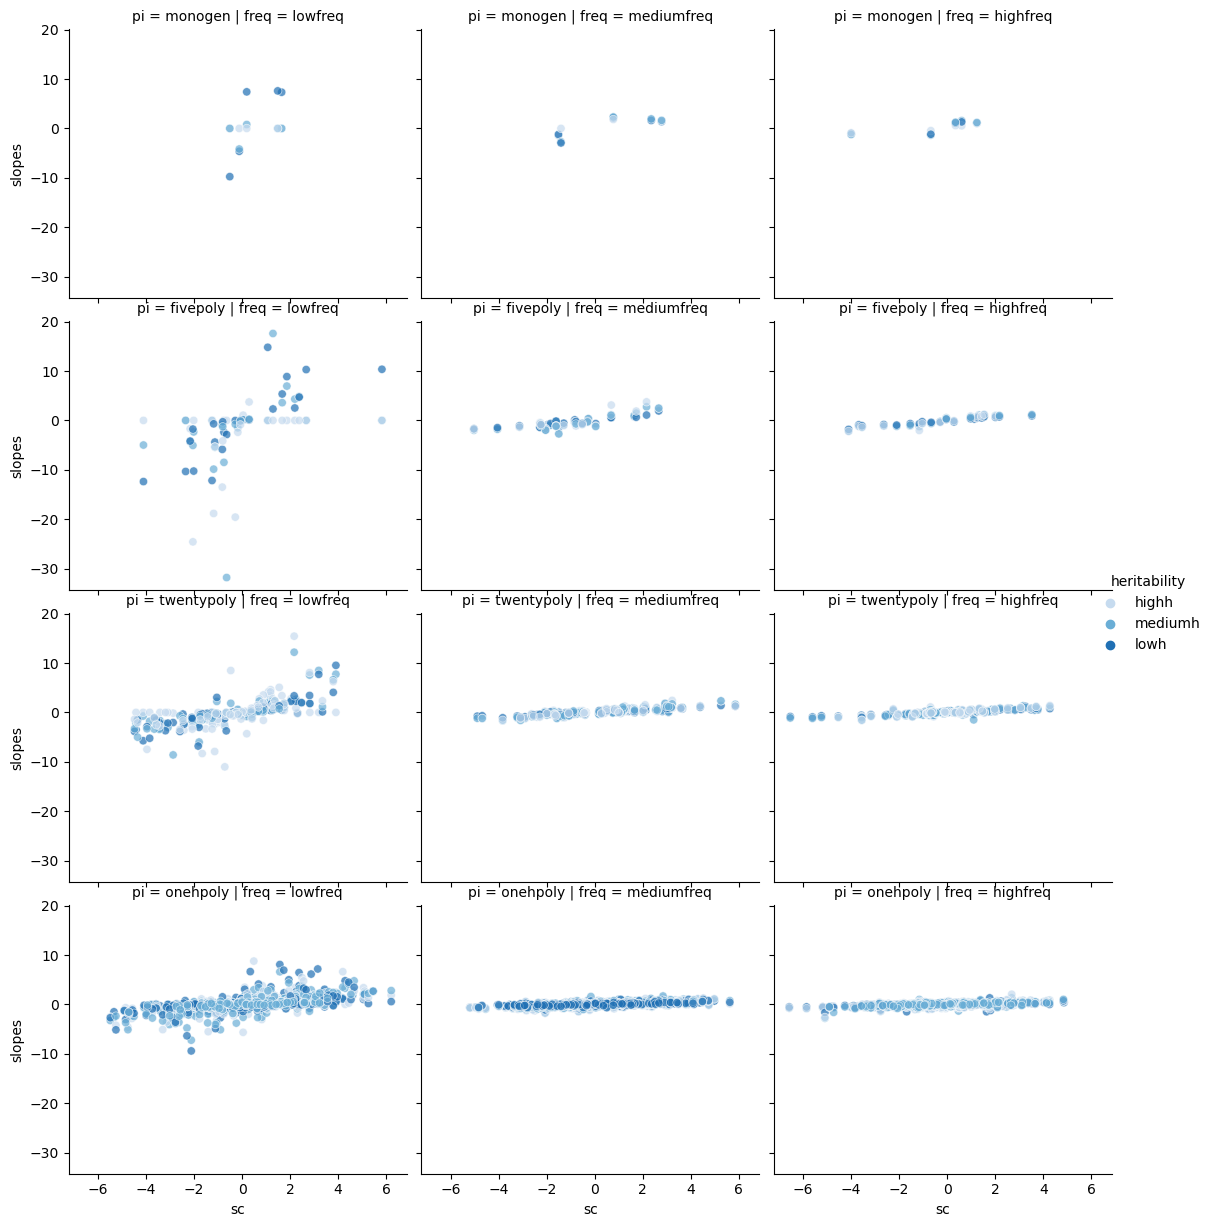

In [143]:
g = sns.relplot(data=delta_p_norm, x="sc", y="slopes", hue='heritability', col="freq", row="pi",
                hue_order = her_order,
                palette=custom_color_dict,
                row_order = pi_order,alpha=0.7,
                col_order = col_order
           )
g.fig.set_figheight(12)
g.fig.set_figwidth(12)
plt.show()

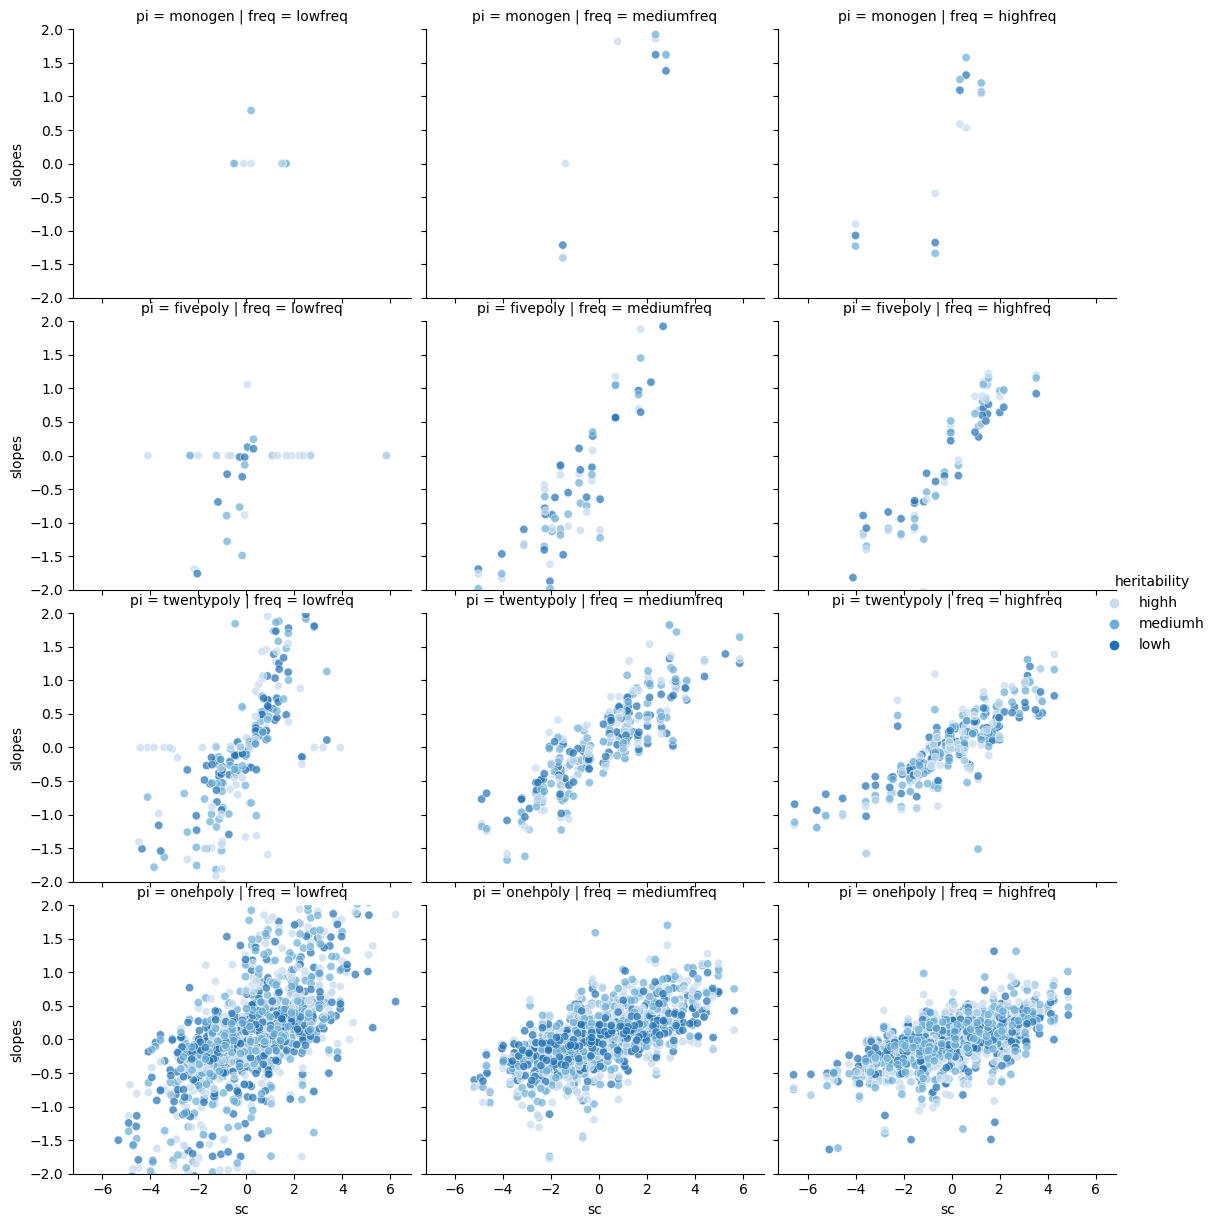

In [149]:
g = sns.relplot(data=delta_p_norm, x="sc", y="slopes", hue='heritability', col="freq", row="pi",
                hue_order = her_order,
                palette=custom_color_dict,
                row_order = pi_order,alpha=0.7,
                col_order = col_order
           )
g.fig.set_figheight(12)
g.fig.set_figwidth(12)
g.set(ylim=(-2, +2))  # Replace 'lower_limit' and 'upper_limit' with your desired limits

plt.show()

In [146]:
allele_freq

,chrom_pos,p_values,slopes,model,sc,heritability,freq,pi,rep
0,1135459,1.900032e-01,-0.004782,allele_freq,1.042827,mediumh,highfreq,onehpoly,4
1,2710060,6.292095e-01,-0.007902,allele_freq,-2.276421,mediumh,highfreq,onehpoly,4
2,2864723,1.688041e-01,-0.014866,allele_freq,1.381345,mediumh,highfreq,onehpoly,4
3,3387729,4.503029e-11,-0.035270,allele_freq,-1.027103,mediumh,highfreq,onehpoly,4
4,9831114,4.282210e-03,-0.018934,allele_freq,1.895886,mediumh,highfreq,onehpoly,4
...,...,...,...,...,...,...,...,...,...
16995,9645484,2.011566e-05,-0.299488,allele_freq,-4.004391,mediumh,highfreq,monogen,5
16998,9645484,7.837851e-02,-0.220000,allele_freq,-4.004391,highh,highfreq,monogen,5
17001,53971167,8.292471e-02,0.065256,allele_freq,1.485009,lowh,lowfreq,monogen,4
17004,53971167,NaN,0.000000,allele_freq,1.485009,mediumh,lowfreq,monogen,4


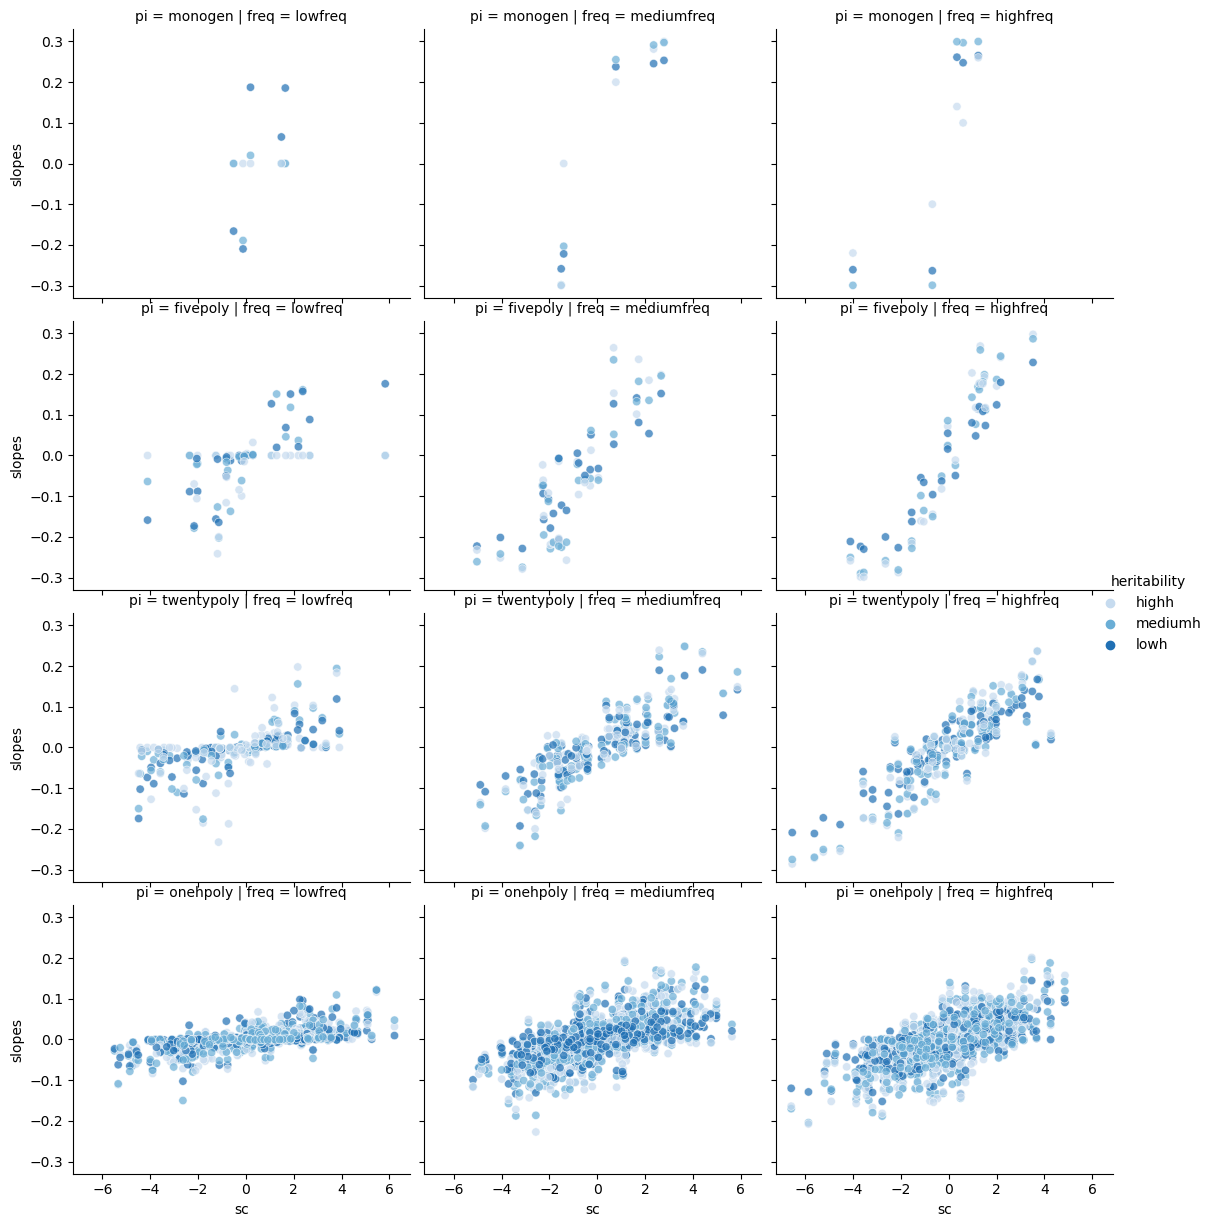

In [147]:
g = sns.relplot(data=allele_freq, x="sc", y="slopes", hue='heritability', col="freq", row="pi",
                hue_order = her_order,
                palette=custom_color_dict,
                row_order = pi_order,alpha=0.7,
                col_order = col_order
           )
g.fig.set_figheight(12)
g.fig.set_figwidth(12)
plt.show()

In [75]:
(allele_freq.reset_index(drop=True) == delta_p.reset_index(drop=True)).sum()

sc              5670
variable           0
value           2941
heritability    5670
freq            5670
pi              5670
rep             5670
dtype: int64

In [71]:
delta_p

,sc,variable,value,heritability,freq,pi,rep
100,-0.0429,rsquared_valuesdelta_p,0.002902,mediumh,highfreq,onehpoly,4
101,-0.0973,rsquared_valuesdelta_p,0.003198,mediumh,highfreq,onehpoly,4
102,0.1062,rsquared_valuesdelta_p,0.000022,mediumh,highfreq,onehpoly,4
103,0.1542,rsquared_valuesdelta_p,0.000348,mediumh,highfreq,onehpoly,4
104,-0.1678,rsquared_valuesdelta_p,0.004052,mediumh,highfreq,onehpoly,4
...,...,...,...,...,...,...,...
16996,-4.0044,rsquared_valuesdelta_p,NaN,mediumh,highfreq,monogen,5
16999,-4.0044,rsquared_valuesdelta_p,NaN,highh,highfreq,monogen,5
17002,1.4850,rsquared_valuesdelta_p,NaN,lowh,lowfreq,monogen,4
17005,1.4850,rsquared_valuesdelta_p,NaN,mediumh,lowfreq,monogen,4


In [150]:
highh

,chrom_pos,p_values,slopes,model,sc,heritability,freq,pi,rep
600,1135459,0.486708,-0.003470,allele_freq,1.042827,highh,highfreq,onehpoly,4
601,2710060,0.037688,-0.052708,allele_freq,-2.276421,highh,highfreq,onehpoly,4
602,2864723,0.523520,-0.017598,allele_freq,1.381345,highh,highfreq,onehpoly,4
603,3387729,0.000020,-0.036144,allele_freq,-1.027103,highh,highfreq,onehpoly,4
604,9831114,0.046607,-0.023332,allele_freq,1.895886,highh,highfreq,onehpoly,4
...,...,...,...,...,...,...,...,...,...
16391,117619319,0.995801,0.002143,delta_p_norm,1.514083,highh,mediumfreq,onehpoly,4
16998,9645484,0.078379,-0.220000,allele_freq,-4.004391,highh,highfreq,monogen,5
16999,9645484,0.078379,-0.220000,delta_p,-4.004391,highh,highfreq,monogen,5
17000,9645484,0.078379,-0.903171,delta_p_norm,-4.004391,highh,highfreq,monogen,5


In [161]:
highh

,chrom_pos,p_values,slopes,model,sc,heritability,freq,pi,rep
600,1135459,0.486708,-0.003470,allele_freq,1.042827,highh,highfreq,onehpoly,4
601,2710060,0.037688,-0.052708,allele_freq,-2.276421,highh,highfreq,onehpoly,4
602,2864723,0.523520,-0.017598,allele_freq,1.381345,highh,highfreq,onehpoly,4
603,3387729,0.000020,-0.036144,allele_freq,-1.027103,highh,highfreq,onehpoly,4
604,9831114,0.046607,-0.023332,allele_freq,1.895886,highh,highfreq,onehpoly,4
...,...,...,...,...,...,...,...,...,...
16391,117619319,0.995801,0.002143,delta_p_norm,1.514083,highh,mediumfreq,onehpoly,4
16998,9645484,0.078379,-0.220000,allele_freq,-4.004391,highh,highfreq,monogen,5
16999,9645484,0.078379,-0.220000,delta_p,-4.004391,highh,highfreq,monogen,5
17000,9645484,0.078379,-0.903171,delta_p_norm,-4.004391,highh,highfreq,monogen,5


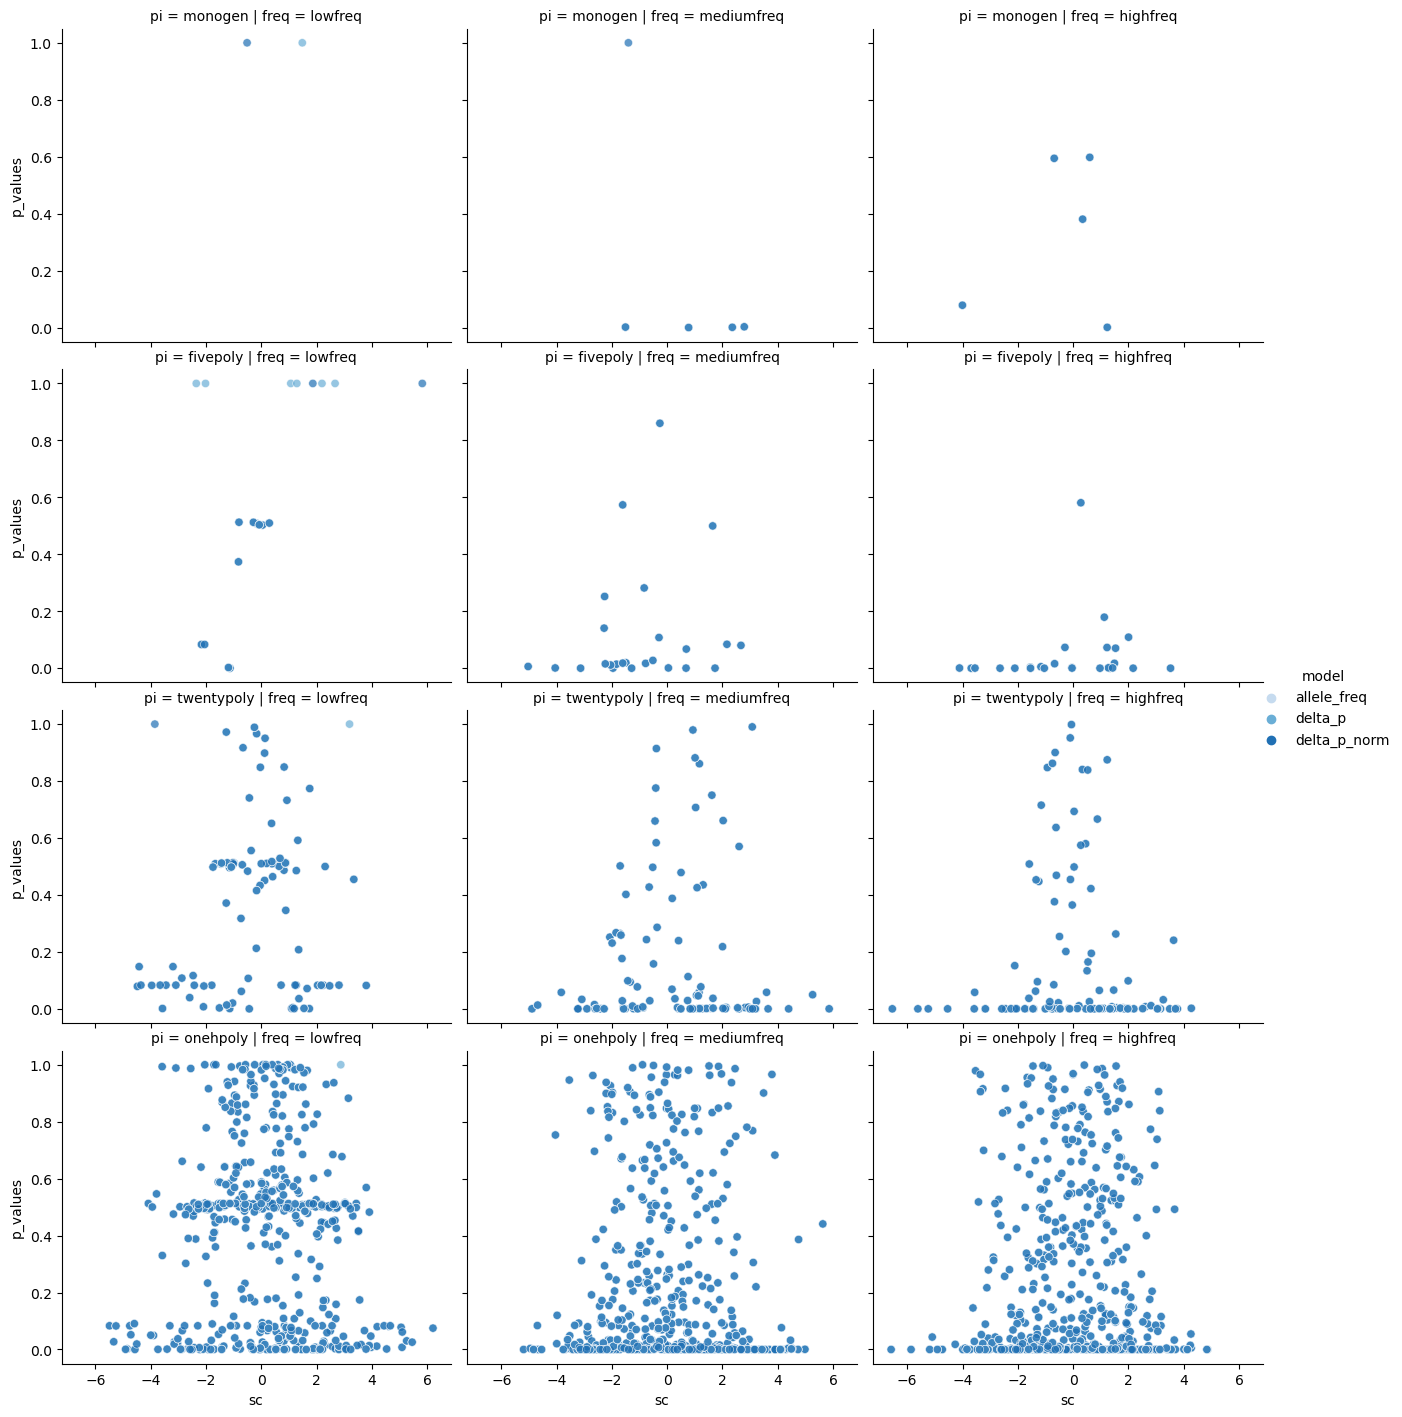

In [162]:
g = sns.relplot(data=highh, x="sc", y="p_values", hue='model', col="freq", row="pi",
                #hue_order = her_order,
                palette=custom_color_dictblues,
                row_order = pi_order,alpha=0.7,
                col_order = col_order
           )
g.fig.set_figheight(14)
g.fig.set_figwidth(14)
#g.set(ylim=(0, 0.05)) 
plt.show()

In [142]:
g = sns.relplot(data=highh, x="sc", y="p_values", hue='model', col="freq", row="pi",
                #hue_order = her_order,
                palette=custom_color_dictblues,
                row_order = pi_order,alpha=0.7,
                col_order = col_order
           )
g.fig.set_figheight(14)
g.fig.set_figwidth(14)
plt.show()

,chrom_pos,p_values,slopes,model,sc,heritability,freq,pi,rep
200,1135459,1.900032e-01,-0.373059,delta_p_norm,1.042827,mediumh,highfreq,onehpoly,4
201,2710060,6.292095e-01,-0.036294,delta_p_norm,-2.276421,mediumh,highfreq,onehpoly,4
202,2864723,1.688041e-01,-0.063614,delta_p_norm,1.381345,mediumh,highfreq,onehpoly,4
203,3387729,4.503029e-11,-0.580877,delta_p_norm,-1.027103,mediumh,highfreq,onehpoly,4
204,9831114,4.282210e-03,-0.263520,delta_p_norm,1.895886,mediumh,highfreq,onehpoly,4
...,...,...,...,...,...,...,...,...,...
16997,9645484,2.011566e-05,-1.229495,delta_p_norm,-4.004391,mediumh,highfreq,monogen,5
17000,9645484,7.837851e-02,-0.903171,delta_p_norm,-4.004391,highh,highfreq,monogen,5
17003,53971167,8.292471e-02,7.602894,delta_p_norm,1.485009,lowh,lowfreq,monogen,4
17006,53971167,NaN,0.000000,delta_p_norm,1.485009,mediumh,lowfreq,monogen,4


In [197]:
5e-8

5e-08

In [230]:
delta_p_norm = delta_p_norm.drop('color',axis=1)

In [43]:
delta_p_norm = delta_p_norm.reset_index(drop=True)

In [44]:
delta_p_normh = delta_p_norm[delta_p_norm['heritability'] == 'highh']
delta_p_norml = delta_p_norm[delta_p_norm['heritability'] == 'highh']

In [45]:
delta_p_normh

,chrom_pos,p_values,slopes,model,sc,heritability,freq,pi,rep
198,1135459,4.867083e-01,-0.270706,delta_p_norm,1.042827,highh,highfreq,onehpoly,4
199,2710060,3.768763e-02,-0.242086,delta_p_norm,-2.276421,highh,highfreq,onehpoly,4
200,2864723,5.235204e-01,-0.075304,delta_p_norm,1.381345,highh,highfreq,onehpoly,4
201,3387729,2.032490e-05,-0.595272,delta_p_norm,-1.027103,highh,highfreq,onehpoly,4
202,9831114,4.660732e-02,-0.324731,delta_p_norm,1.895886,highh,highfreq,onehpoly,4
...,...,...,...,...,...,...,...,...,...
5428,115027086,8.945105e-29,-0.396185,delta_p_norm,0.365421,highh,mediumfreq,onehpoly,4
5429,117188081,5.757146e-37,-0.398956,delta_p_norm,-2.917107,highh,mediumfreq,onehpoly,4
5430,117619319,9.958011e-01,0.002143,delta_p_norm,1.514083,highh,mediumfreq,onehpoly,4
5631,9645484,7.837851e-02,-0.903171,delta_p_norm,-4.004391,highh,highfreq,monogen,5


In [46]:
# Define a function to assign colors based on a condition
def assign_color(value):
    if value < 5e-8:
        return (1.0, 0.0, 0.0)  # Red color
    else:
        return (0.7, 0.7, 0.7)  # Grey color

# Create a color dictionary by applying the function to each value in the column
color_values= [assign_color(value) for value in delta_p_normh['p_values']]
color_dict = {(0.7, 0.7, 0.7): (0.7, 0.7, 0.7), (1.0, 0.0, 0.0):(1.0, 0.0, 0.0)}


In [47]:
len(color_values)

1869

In [48]:
delta_p_normh.loc[:,'color'] = color_values

/tmp/ipykernel_171093/3947765341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_p_normh.loc[:,'color'] = color_values


In [49]:
delta_p_normh['color'].value_counts()

(0.7, 0.7, 0.7)    1718
(1.0, 0.0, 0.0)     151
Name: color, dtype: int64

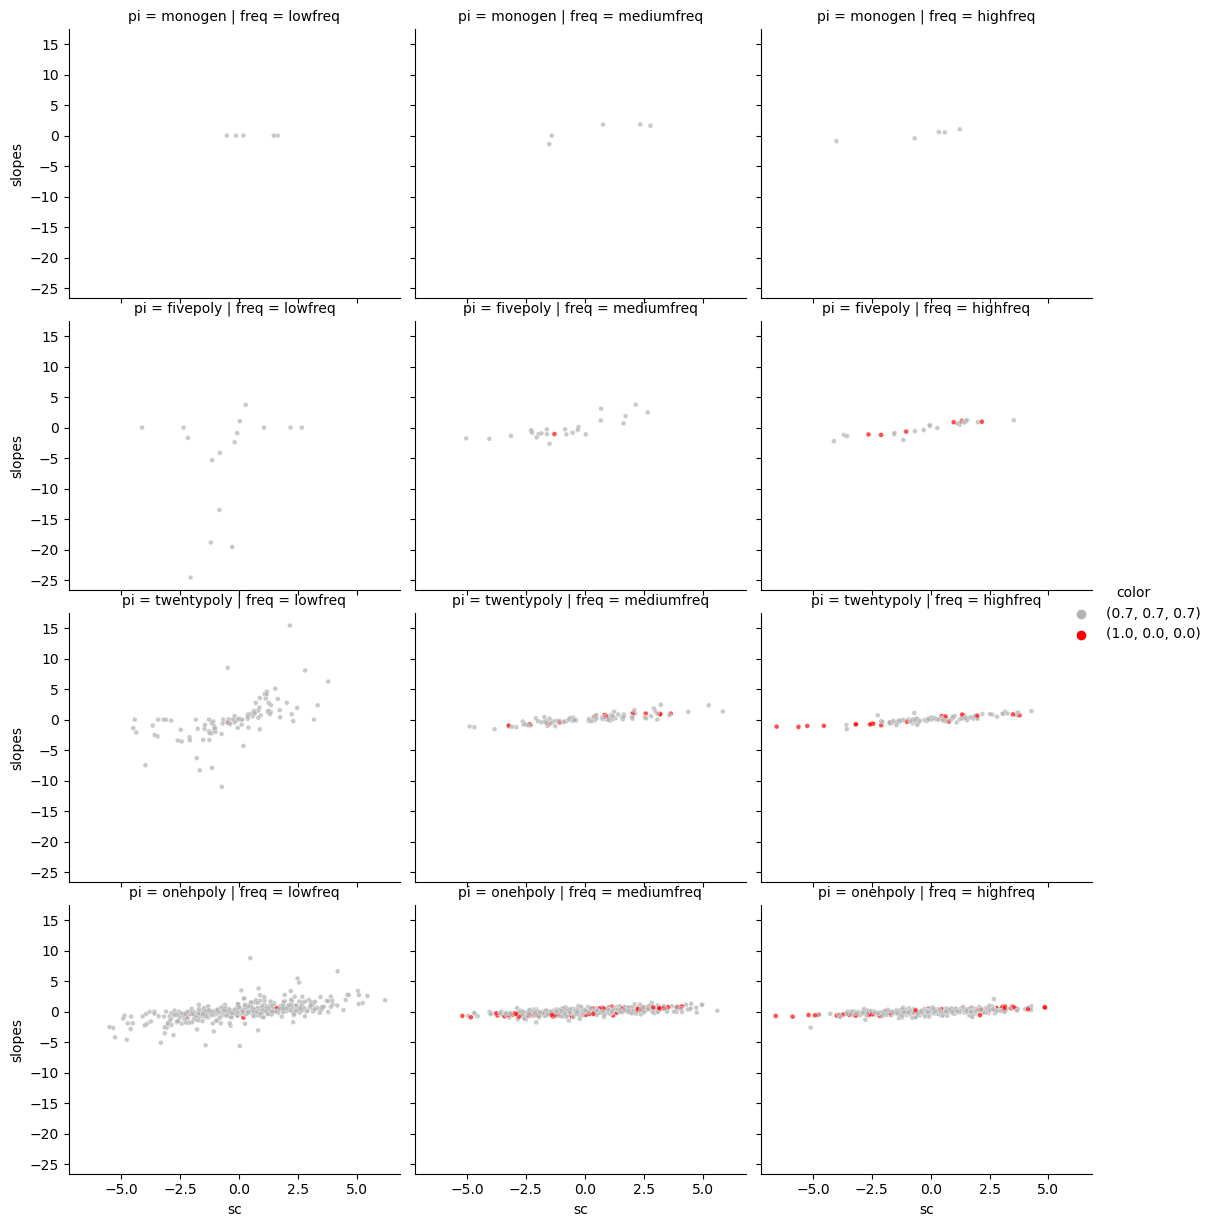

In [50]:
g = sns.relplot(data=delta_p_normh, x="sc", y="slopes", hue='color', col="freq", row="pi",
                #hue_order = her_order,
                palette=color_dict,
                s=12,
                row_order = pi_order,alpha=0.7,
                
                col_order = col_order
           )
g.fig.set_figheight(12)
g.fig.set_figwidth(12)
plt.show()

In [51]:
# Define a function to assign colors based on a condition
def assign_color(value):
    if value < 5e-8:
        return (1.0, 0.0, 0.0)  # Red color
    else:
        return (0.7, 0.7, 0.7)  # Grey color

# Create a color dictionary by applying the function to each value in the column
color_values= [assign_color(value) for value in delta_p_norml['p_values']]
color_dict = {(0.7, 0.7, 0.7): (0.7, 0.7, 0.7), (1.0, 0.0, 0.0):(1.0, 0.0, 0.0)}


In [52]:
delta_p_norml.loc[:,'color'] = color_values

/tmp/ipykernel_171093/780091261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_p_norml.loc[:,'color'] = color_values


In [53]:
delta_p_norml['color'].value_counts()

(0.7, 0.7, 0.7)    1718
(1.0, 0.0, 0.0)     151
Name: color, dtype: int64

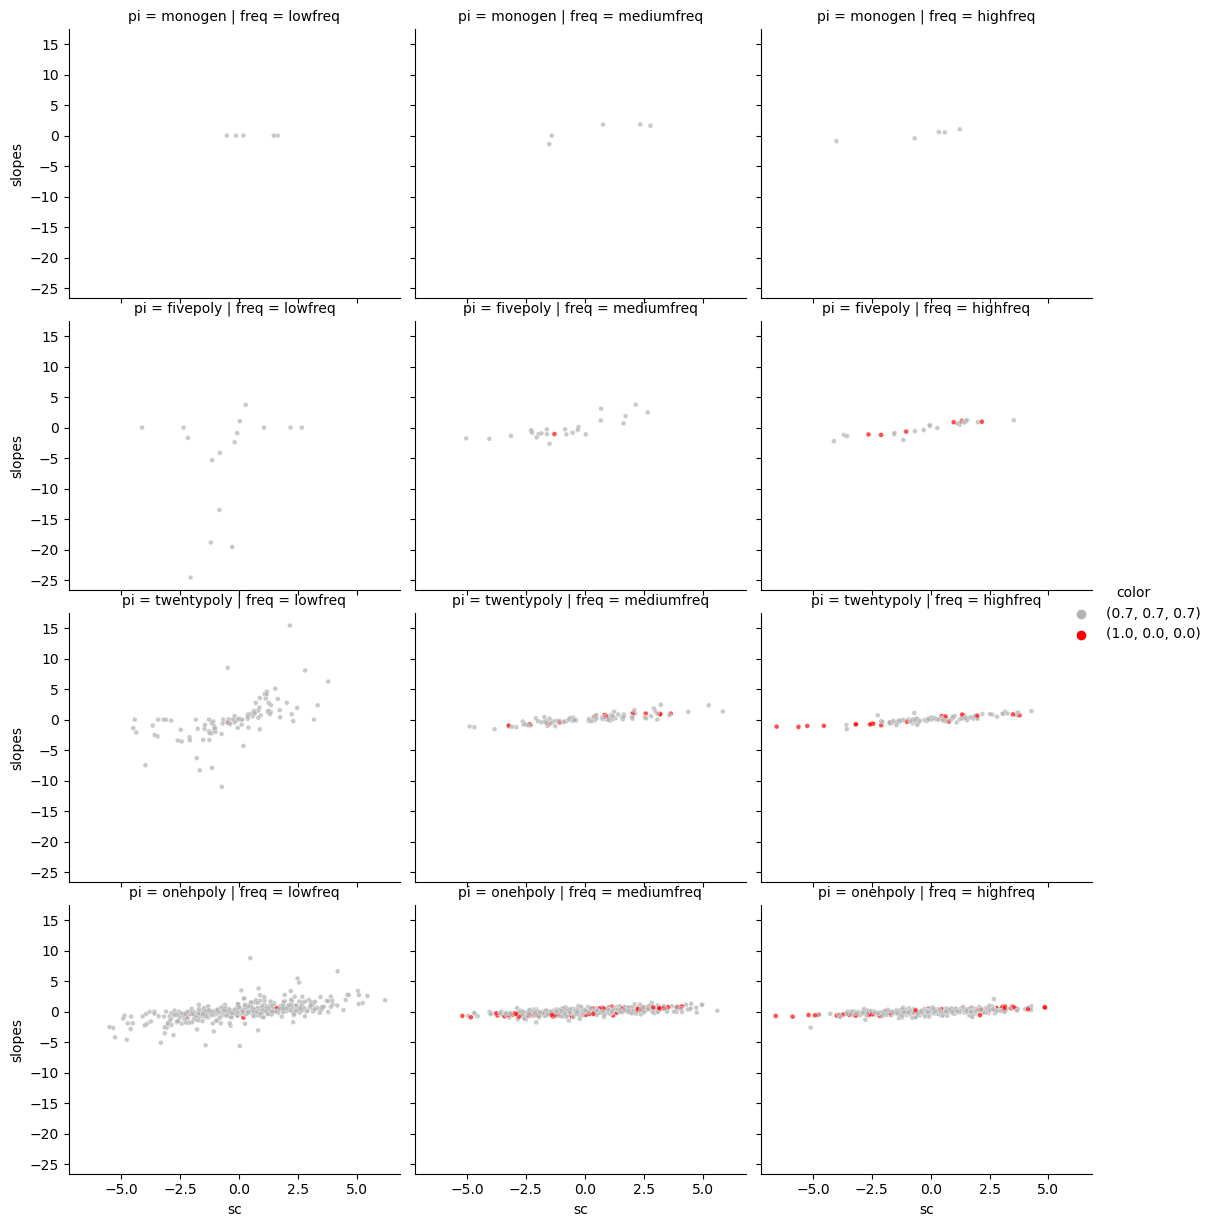

In [54]:
g = sns.relplot(data=delta_p_norml, x="sc", y="slopes", hue='color', col="freq", row="pi",
                #hue_order = her_order,
                palette=color_dict,
                s=12,
                row_order = pi_order,alpha=0.7,
                
                col_order = col_order
           )
g.fig.set_figheight(12)
g.fig.set_figwidth(12)
plt.show()